## Original Class

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.linear_model import Ridge


def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

class GlobalMeanRS(BaseEstimator):
    def __init__(self):
        self.global_mean_ = 0

    def fit(self, X, y):
        self.global_mean_ = np.mean(y)
        return self

    def predict(self, X):
        return self.global_mean_*np.ones(len(X))

class UserMeanRS(BaseEstimator):
    def __init__(self, n_users, min_data=3):
        self.n_users = n_users
        self.global_mean_ = 0
        self.min_data = min_data
        self.user_means_ = np.zeros(n_users)

    def fit(self, X, y):
        self.global_mean_ = np.mean(y)
        for user in range(self.n_users):
            user_indices = np.where(X[:, 0] == user)[0]
            if len(user_indices) <= self.min_data:
                self.user_means_[user] = self.global_mean_
            else:
                self.user_means_[user] = np.mean(y[user_indices])
        return self

    def predict(self, X):
        user_indices = X[:, 0]
        return self.user_means_[user_indices]

class ItemMeanRS(BaseEstimator):
    def __init__(self, n_items, min_data=3):
        self.n_items = n_items
        self.global_mean_ = 0
        self.min_data = min_data
        self.item_means_ = np.zeros(n_items)

    def fit(self, X, y):
        self.global_mean_ = np.mean(y)
        for item in range(self.n_items):
            item_indices = np.where(X[:, 1] == item)[0]
            if len(item_indices) <= self.min_data:
                self.item_means_[item] = self.global_mean_
            else:
                self.item_means_[item] = np.mean(y[item_indices])
        return self

    def predict(self, X):
        item_indices = X[:, 1]
        return self.item_means_[item_indices]

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.linear_model import Ridge   # (Not used here, but imported in original template)


# -------------------------------------------
# RMSE function (Root Mean Squared Error)
# Measures prediction accuracy.
# -------------------------------------------
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))


# ============================================================
#                 Global Mean Recommender
# ============================================================
class GlobalMeanRS(BaseEstimator):
    def __init__(self):
        self.global_mean_ = 0   # will store the overall mean rating

    def fit(self, X, y):
        # compute global mean: mean of all ratings in training data
        self.global_mean_ = np.mean(y)
        return self

    def predict(self, X):
        # predict the same global mean value for every (user, item) pair
        return self.global_mean_ * np.ones(len(X))


# ============================================================
#                 User Mean Recommender
# ============================================================
class UserMeanRS(BaseEstimator):
    def __init__(self, n_users, min_data=3):
        self.n_users = n_users              # total number of users
        self.global_mean_ = 0               # fallback mean
        self.min_data = min_data            # minimum #ratings needed
        self.user_means_ = np.zeros(n_users)  # store each user's mean rating

    def fit(self, X, y):
        self.global_mean_ = np.mean(y)      # compute global mean

        # loop over all users to compute user-specific means
        for user in range(self.n_users):
            # find all training rows where user == current user
            user_indices = np.where(X[:, 0] == user)[0]

            # if user has too few ratings, fallback to global mean
            if len(user_indices) <= self.min_data:
                self.user_means_[user] = self.global_mean_
            else:
                # otherwise compute that user's mean rating
                self.user_means_[user] = np.mean(y[user_indices])

        return self

    def predict(self, X):
        # X[:,0] gives the list of user IDs
        user_indices = X[:, 0]
        # return each user's mean rating as prediction
        return self.user_means_[user_indices]


# ============================================================
#                 Item Mean Recommender
# ============================================================
class ItemMeanRS(BaseEstimator):
    def __init__(self, n_items, min_data=3):
        self.n_items = n_items               # total number of items
        self.global_mean_ = 0                # fallback mean
        self.min_data = min_data             # minimum #ratings needed
        self.item_means_ = np.zeros(n_items)  # store item means

    def fit(self, X, y):
        self.global_mean_ = np.mean(y)       # compute global mean

        # loop over all items to compute item-specific means
        for item in range(self.n_items):
            # find all training rows where item == current item
            item_indices = np.where(X[:, 1] == item)[0]

            # if item has too few ratings, fallback to global mean
            if len(item_indices) <= self.min_data:
                self.item_means_[item] = self.global_mean_
            else:
                # otherwise compute item's mean rating
                self.item_means_[item] = np.mean(y[item_indices])

        return self

    def predict(self, X):
        # X[:,1] gives the list of item IDs
        item_indices = X[:, 1]
        # return each item's mean rating as prediction
        return self.item_means_[item_indices]


In [5]:
 class SVD(BaseEstimator):
    def __init__(self, n_users, n_items, lam=.01, K=5, iterNum=10, tol=1e-4, verbose=1):
        self.mu = 0.0
        self.a = np.zeros(n_users)
        self.b = np.zeros(n_items)
        self.P = np.random.randn(n_users, K)
        self.Q = np.random.randn(n_items, K)
        self.n_users = n_users
        self.n_items = n_items
        self.K = K
        self.lam = lam
        self.iterNum = iterNum
        self.tol = tol
        self.verbose = verbose

    def fit(self, X, y):
        diff = 1.0
        n_users, n_items, n_obs = self.n_users, self.n_items, len(X)
        K, lam = self.K, self.lam

        if self.verbose:
            print('Fitting Reg-SVD: K: %d, lam: %.5f' %(self.K, self.lam))

        self.index_item = [np.where(X[:,1] == i)[0] for i in range(n_items)]
        self.index_user = [np.where(X[:,0] == u)[0] for u in range(n_users)]

        for l in range(self.iterNum):
            obj_old = self.obj(X, y)
            self.mu = np.mean(y - self.predict(X) + self.mu)

            for item_id in range(n_items):
                index_item_tmp = self.index_item[item_id]
                if len(index_item_tmp) == 0:
                    self.Q[item_id,:] = 0.0
                    continue
                y_tmp = y[index_item_tmp]
                X_tmp = X[index_item_tmp]
                U_tmp = X_tmp[:,0]
                self.b[item_id] = np.mean(y_tmp - self.predict(X_tmp) + self.b[item_id])
                res_tmp = y_tmp - self.mu - self.b[item_id] - self.a[U_tmp]
                P_tmp = self.P[U_tmp]
                clf = Ridge(alpha=lam*n_obs, fit_intercept=False)
                clf.fit(X=P_tmp, y=res_tmp)
                self.Q[item_id,:] = clf.coef_

            for user_id in range(n_users):
                index_user_tmp = self.index_user[user_id]
                if len(index_user_tmp) == 0:
                    self.P[user_id,:] = 0.0
                    continue
                y_tmp = y[index_user_tmp]
                X_tmp = X[index_user_tmp]
                I_tmp = X_tmp[:,1]
                self.a[user_id] = np.mean(y_tmp - self.predict(X_tmp) + self.a[user_id])
                res_tmp = y_tmp - self.mu - self.b[I_tmp] - self.a[user_id]
                Q_tmp = self.Q[I_tmp]
                clf = Ridge(alpha=lam*n_obs, fit_intercept=False)
                clf.fit(X=Q_tmp, y=res_tmp)
                self.P[user_id,:] = clf.coef_

            obj_new = self.obj(X, y)
            diff = abs(obj_old - obj_new)

            if self.verbose:
                print("RegSVD-ALS: %d; obj: %.3f; rmse:%.3f, diff: %.3f"
                      %(l, obj_new, np.sqrt(self.mse(X,y)), diff))
            if diff < self.tol:
                break
        return self

    def predict(self, X):
        return np.array([self.mu + self.a[u] + self.b[i] + np.dot(self.P[u], self.Q[i])
                         for u, i in X])

    def mse(self, X, y):
        pred_y = self.predict(X)
        return np.mean((pred_y - y)**2)

    def obj(self, X, y):
        mse_tmp = self.mse(X, y)
        pen_tmp = np.sum(self.P**2) + np.sum(self.Q**2)
        return mse_tmp + self.lam * pen_tmp


## **Q1.1: Mean Absolute Percentage Error**

In recommender systems, the accuracy of predicted ratings is crucial. One way to evaluate this accuracy is by computing the Mean Absolute Percentage Error (MAPE) between the actual ratings and the predicted ratings. The MAPE is defined as:

$$
\text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left|\frac{r_i - \hat{r}_i}{r_i}\right| \times 100
$$

where $r_i$ is the actual rating and $\hat{r}_i$ is the predicted rating.

Given the following arrays `actual_ratings` and `predicted_ratings`, compute the MAPE:

```python
import numpy as np

actual_ratings = np.array([4.0, 3.0, 5.0, 2.0, 4.5])
predicted_ratings = np.array([3.8, 3.2, 4.8, 2.2, 4.2])
```

**Task:**

Develop a Python function `MAPE(y_true, y_pred)` to compute the MAPE. Then, use this function to calculate the MAPE for the provided example.

In [25]:
## Your solution here.

import numpy as np

actual_ratings = np.array([4.0, 3.0, 5.0, 2.0, 4.5])
predicted_ratings = np.array([3.8, 3.2, 4.8, 2.2, 4.2])

def MAPE(y_true, y_pred):
  diff = np.abs(y_true - y_pred)
  pct = diff/y_true * 100 # individual pct error
  return np.mean(pct)
MAPE(actual_ratings, predicted_ratings)

6.46666666666667

## **Q1.2: Implementing a Tolerant MAPE Function**

If `r_i` is zero, we may encounter zero-division errors. To address this issue, modify the `MAPE` function to handle zero-division errors when an actual rating `r_i` is zero. Implement **one of the following strategies** to handle this scenario:

1. **Ignore zero-rated items**: Exclude items with zero actual ratings from the MAPE calculation.
2. **Replace zero-rated items with a small value**: Replace actual ratings of zero with a small positive value (e.g., 1e-6) to avoid division by zero.
3. **Use a robust division function**: Implement a robust division function that returns a specific value (e.g., 0 or 1) when the denominator is zero.

**Task:**

Please select *one of the strategies* to implement a new `MAPE` function that handles zero-division errors when an actual rating `r_i` is zero.

In [ ]:
def MAPE(y_true, y_pred):
  diff = np.abs(y_true - y_pred)
  pct = diff/np.maximum(y_true, 0.1) * 100 # individual pct error
  return np.mean(pct)
MAPE(actual_ratings, predicted_ratings)

## **Q2.1: User/Item Median-based Baseline Recsys**


**Task:**

- **Class Development.** Create custom classes `UserMedianRS` and `ItemMedianRS` that inherits from `sklearn.BaseEstimator`. Implement the `fit` method to compute the parameter, and the `predict` method to generate predictions based on the user-/item- median formula:

  - `UserMedianRS`: compute the median of all observed ratings associated with user-$u$:

  $$\widehat{r}_{ui} = r_u^{(m)} = \text{median}\big(\{r_{u i'}\}_{(u,i') \in \Omega}\big)$$

  - `ItemMedianRS`: compute the median of all observed ratings associated with item-$i$:

  $$\widehat{r}_{ui} = r_i^{(m)} = \text{median}\big(\{r_{u' i}\}_{(u',i) \in \Omega}\big)$$



- **Fit and Evaluation.** Fit the custom recommender system to the training data and generate predictions for the test data. Compute and report the Root Mean Squared Error (RMSE) for the predictions.

In [23]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))


# ============================================================
# User Median Recommender System
# ============================================================
class UserMedianRS(BaseEstimator):
    def __init__(self, n_users, min_data=3):
        self.n_users = n_users
        self.min_data = min_data
        self.global_median_ = 0
        self.user_medians_ = np.zeros(n_users)

    def fit(self, X, y):
        self.global_median_ = np.median(y)
        for user in range(self.n_users):
            user_idx = np.where(X[:, 0] == user)[0]
            if len(user_idx) <= self.min_data:
                self.user_medians_[user] = self.global_median_
            else:
                self.user_medians_[user] = np.median(y[user_idx])
        return self

    def predict(self, X):
        user_idx = X[:, 0]
        return self.user_medians_[user_idx]


# ============================================================
# Item Median Recommender System
# ============================================================
class ItemMedianRS(BaseEstimator):
    def __init__(self, n_items, min_data=3):
        self.n_items = n_items
        self.min_data = min_data
        self.global_median_ = 0
        self.item_medians_ = np.zeros(n_items)

    def fit(self, X, y):
        self.global_median_ = np.median(y)
        for item in range(self.n_items):
            item_idx = np.where(X[:, 1] == item)[0]
            if len(item_idx) <= self.min_data:
                self.item_medians_[item] = self.global_median_
            else:
                self.item_medians_[item] = np.median(y[item_idx])
        return self

    def predict(self, X):
        item_idx = X[:, 1]
        return self.item_medians_[item_idx]


# ============================================================
# Load Netflix Dataset
# ============================================================
train = pd.read_csv(
    "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/netflix/train.csv"
)
test = pd.read_csv(
    "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/netflix/test.csv"
)

# Convert to NumPy arrays
X_train = train[['user_id', 'movie_id']].values
y_train = train['rating'].values

X_test = test[['user_id', 'movie_id']].values
y_test = test['rating'].values

n_users = train['user_id'].max() + 1
n_items = train['movie_id'].max() + 1


# ============================================================
# Fit and Evaluate User Median RS
# ============================================================
u_median = UserMedianRS(n_users=n_users)
u_median.fit(X_train, y_train)
pred_u = u_median.predict(X_test)
rmse_u = rmse(y_test, pred_u)

print("User Median RS RMSE:", rmse_u)


# ============================================================
# Fit and Evaluate Item Median RS
# ============================================================
i_median = ItemMedianRS(n_items=n_items)
i_median.fit(X_train, y_train)
pred_i = i_median.predict(X_test)
rmse_i = rmse(y_test, pred_i)

print("Item Median RS RMSE:", rmse_i)


User Median RS RMSE: 1.0792378805285392
Item Median RS RMSE: 1.1027923532447133


## **Q2.1 more**

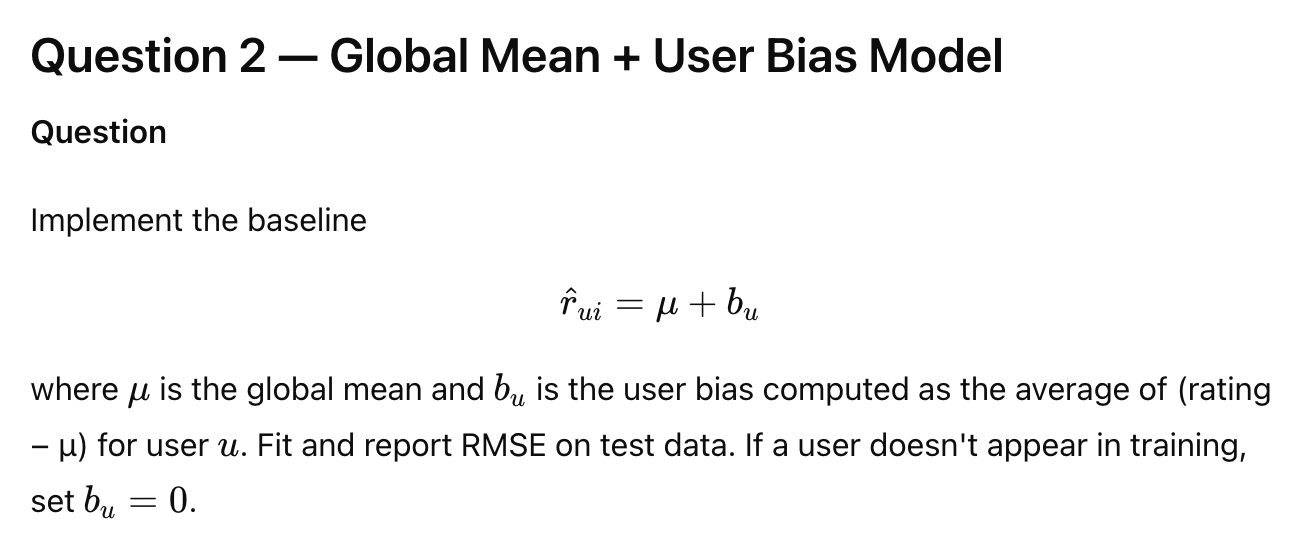

In [ ]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


class GlobalPlusUserBiasRS(BaseEstimator):
    """
    Predict: mu + b_u, where b_u = mean(r_ui - mu) for each user
    """
    def __init__(self, n_users=None):
        self.n_users = n_users
        self.global_mean_ = 0.0
        self.user_bias_ = None
        self.user_counts_ = None

    def fit(self, X, y):
        if self.n_users is None:
            self.n_users = int(X[:, 0].max()) + 1

        self.global_mean_ = np.mean(y)
        self.user_bias_ = np.zeros(self.n_users, dtype=float)
        self.user_counts_ = np.zeros(self.n_users, dtype=int)

        # accumulate sum of deviations and counts
        sums = np.zeros(self.n_users, dtype=float)
        counts = np.zeros(self.n_users, dtype=int)
        for i, (u, item) in enumerate(X.astype(int)):
            sums[u] += (y[i] - self.global_mean_)
            counts[u] += 1

        # compute bias = average deviation per user (0 if no data)
        for u in range(self.n_users):
            if counts[u] > 0:
                self.user_bias_[u] = sums[u] / counts[u]
            else:
                self.user_bias_[u] = 0.0
        self.user_counts_ = counts
        return self

    def predict(self, X):
        users = X[:, 0].astype(int)
        preds = np.zeros(len(users), dtype=float)
        for i, u in enumerate(users):
            b_u = self.user_bias_[u] if u < len(self.user_bias_) else 0.0
            preds[i] = self.global_mean_ + b_u
        return preds


# ------------------------------
# Load dataset
# ------------------------------
train = pd.read_csv(
    "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/netflix/train.csv"
)
test = pd.read_csv(
    "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/netflix/test.csv"
)

X_train = train[['User', 'Item']].values
y_train = train['Rating'].values
X_test = test[['User', 'Item']].values
y_test = test['Rating'].values

n_users = int(max(train['User'].max(), test['User'].max())) + 1

# Fit and evaluate
model = GlobalPlusUserBiasRS(n_users=n_users)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("GlobalPlusUserBiasRS RMSE:", rmse(y_test, preds))


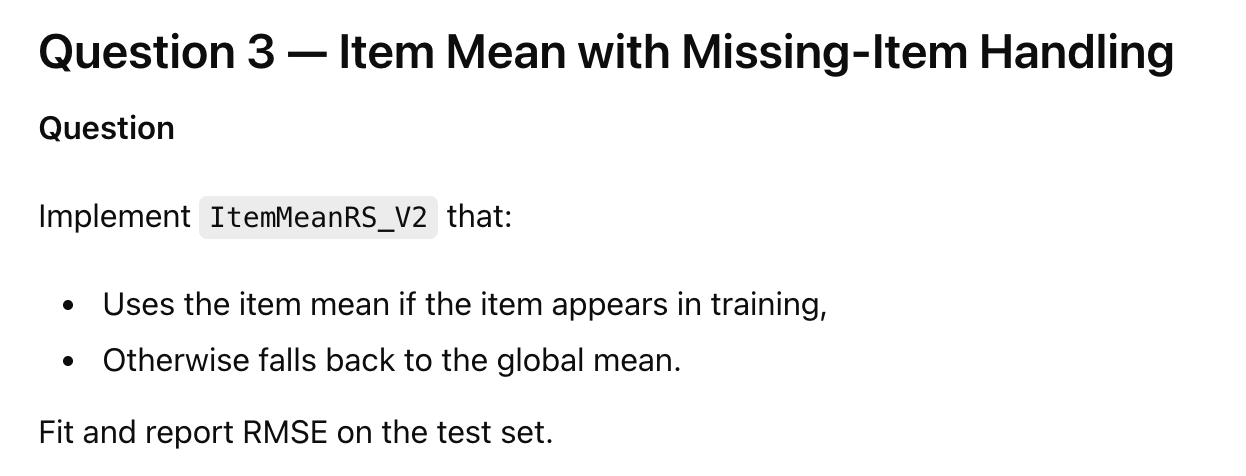

In [ ]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


class ItemMeanRS_V2(BaseEstimator):
    """
    Item mean recommender with explicit handling for unseen items:
      - if item seen in training: predict item mean
      - else: predict global mean
    """
    def __init__(self, n_items=None):
        self.n_items = n_items
        self.global_mean_ = 0.0
        self.item_means_ = None
        self.item_counts_ = None

    def fit(self, X, y):
        if self.n_items is None:
            self.n_items = int(X[:, 1].max()) + 1

        self.global_mean_ = np.mean(y)
        self.item_means_ = np.full(self.n_items, self.global_mean_, dtype=float)
        self.item_counts_ = np.zeros(self.n_items, dtype=int)

        sums = np.zeros(self.n_items, dtype=float)
        counts = np.zeros(self.n_items, dtype=int)
        for i, (u, item) in enumerate(X.astype(int)):
            sums[item] += y[i]
            counts[item] += 1

        for it in range(self.n_items):
            if counts[it] > 0:
                self.item_means_[it] = sums[it] / counts[it]
            else:
                self.item_means_[it] = self.global_mean_
        self.item_counts_ = counts
        return self

    def predict(self, X):
        items = X[:, 1].astype(int)
        preds = np.zeros(len(items), dtype=float)
        for i, it in enumerate(items):
            if it < len(self.item_means_) and self.item_counts_[it] > 0:
                preds[i] = self.item_means_[it]
            else:
                preds[i] = self.global_mean_
        return preds


# ------------------------------
# Load dataset
# ------------------------------
train = pd.read_csv(
    "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/netflix/train.csv"
)
test = pd.read_csv(
    "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/netflix/test.csv"
)

X_train = train[['User', 'Item']].values
y_train = train['Rating'].values
X_test = test[['User', 'Item']].values
y_test = test['Rating'].values

n_items = int(max(train['Item'].max(), test['Item'].max())) + 1

# Fit and evaluate
model = ItemMeanRS_V2(n_items=n_items)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("ItemMeanRS_V2 RMSE:", rmse(y_test, preds))


## **Q2.2: Average User/Item Median-based Baseline Recsys**


**Task:**

- **Class Development.** Create a custom class `AveUserItemMedianRS` that inherits from `sklearn.BaseEstimator`. Implement the `fit` method to compute the parameters and the `predict` method to generate predictions based on the average of user-item median formula:

$$
\widehat{r}_{ui} = \frac{1}{2}\big( r_{u}^{(m)} + r_{i}^{(m)} \big),
$$
where $r_{u}^{(m)}$ and $r_{i}^{(m)}$ are defined previously.

- **Fit and Evaluation.** Fit the custom recommender system to the training data and generate predictions for the test data. Compute and report the Root Mean Squared Error (RMSE) for the predictions.

In [26]:
from sklearn.base import BaseEstimator

class AveUserItemMedianRS(BaseEstimator):
    def __init__(self, n_user, n_item, min_data=3):
        self.n_user = n_user
        self.n_item = n_item
        self.min_data = min_data
        
        # use your own median-based baseline models
        self.user = UserMedianRS(n_user, min_data=min_data)
        self.item = ItemMedianRS(n_item, min_data=min_data)

    def fit(self, X, y):
        self.user.fit(X, y)
        self.item.fit(X, y)
        return self

    def predict(self, X):
        user_pred = self.user.predict(X)
        item_pred = self.item.predict(X)
        return 0.5 * (user_pred + item_pred)

avg_pred = AveUserItemMedianRS(n_user, n_item).fit(train-1, y_train).predict(test)
root_mean_squared_error(avg_pred, y_test)


TypeError: unsupported operand type(s) for -: 'str' and 'int'

## **Q3.1: Basic Usage**

Import the `SVD` class from our GitHub repository: https://github.com/statmlben/CUHK-STAT3009/blob/main/src/TabRS.py.

You will implement a SVD model using the Netflix dataset from the CUHK-STAT3009 GitHub repository.

```python
import numpy as np
import pandas as pd

# Load the Netflix dataset from the CUHK-STAT3009 GitHub repository
# Repository link: https://github.com/statmlben/CUHK-STAT3009/tree/main/dataset/netflix

train = pd.read_csv('https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/netflix/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/netflix/test.csv')

# Convert DataFrame to NumPy arrays
```

**Task:**

Your task is to train an `SVD` model with $K = 10$ and $\lambda = 0.02$ using the provided dataset and predict the ratings for the test dataset.

> The correctness of the implementation will be evaluated based on the code structure and logic, not on the final evaluation results.

In [20]:
user="statmlben"
repo="CUHK-STAT3009"
src="src"
pyfile="TabRS.py"

url=f"https://raw.githubusercontent.com/{user}/{repo}/main/{src}/{pyfile}"

!curl -L -O "$url"




  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9001  100  9001    0     0  20148      0 --:--:-- --:--:-- --:--:-- 20181


In [21]:
import numpy as np
import pandas as pd
from TabRS import SVD
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load datasets
train_df = pd.read_csv('https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/netflix/train.csv')
test_df  = pd.read_csv('https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/netflix/test.csv')

# Prepare arrays
y_train = train_df["rating"].values
y_test  = test_df["rating"].values

# The SVD class requires 0-indexed IDs
train = train_df[["user_id", "movie_id"]].values - 1
test  = test_df[["user_id", "movie_id"]].values - 1

# Number of users/items
n_user = train_df["user_id"].max()
n_item = train_df["movie_id"].max()

# Train SVD model
svd = SVD(n_user, n_item, K=10, lam=0.02)
svd.fit(train, y_train)

# Predict
svd_pred = svd.predict(test)

# RMSE
rmse = sqrt(mean_squared_error(y_test, svd_pred))
rmse


Fitting Reg-SVD: K: 10, lam: 0.02000
RegSVD-ALS: 0; obj: 1.329; rmse:1.147, diff: 1136.859
RegSVD-ALS: 1; obj: 0.763; rmse:0.873, diff: 0.566
RegSVD-ALS: 2; obj: 0.760; rmse:0.872, diff: 0.003
RegSVD-ALS: 3; obj: 0.760; rmse:0.872, diff: 0.000
RegSVD-ALS: 4; obj: 0.759; rmse:0.871, diff: 0.000


0.9712916905335623

## **Q3.2: Overfitting and Underfitting** (Multiple-choice question)

### If you receive the following feedback from SVD training and validation evaluation on datasets, you may proceed to:

``` python
	Fitting Reg-SVD: K: 3, lam: 0.00010
	Reg-SVD: ite: 0; diff: 0.527 RMSE: 0.939
	Reg-SVD: ite: 1; diff: 0.050 RMSE: 0.892
	Reg-SVD: ite: 2; diff: 0.042 RMSE: 0.854
	Reg-SVD: ite: 3; diff: 0.021 RMSE: 0.836
	Reg-SVD: ite: 4; diff: 0.010 RMSE: 0.828
	Reg-SVD: ite: 5; diff: 0.006 RMSE: 0.823
	Reg-SVD: ite: 6; diff: 0.003 RMSE: 0.820
	Reg-SVD: ite: 7; diff: 0.002 RMSE: 0.819
	Reg-SVD: ite: 8; diff: 0.001 RMSE: 0.818
	Reg-SVD: ite: 9; diff: 0.000 RMSE: 0.817
	Validation RMSE for SVD: 1.975
```

- (**A**) Increase the number of latent factors (K)

- (**B**) Decrease the number of latent factors (K)

- (**C**) Increase the regularization parameter (λ)

- (**D**) Decrease the regularization parameter (λ)

Correct answers: (B) and (C)
(B) Decrease K

→ Makes model simpler → helps stop overfitting

(C) Increase λ

→ Adds more penalty → reduces overfitting

## **Q3.3: Hyperparameter Optimization for SVD Models**

**Importing the SVD Class**

Download the `SVD` class from our GitHub repository: https://github.com/statmlben/CUHK-STAT3009/blob/main/src/TabRS.py.

**Dataset**

We will use a synthetic dataset to demonstrate the basic usage of SVD for rating prediction. The dataset consists of user ratings for various items, represented by the following DataFrame:
```python
import pandas as pd
data = {
    'user_id': [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10],
    'item_id': [0, 2, 1, 2, 1, 3, 1, 3, 2, 3, 2, 3, 4, 5, 4, 5, 6, 7, 6, 7, 8, 9],
    'rating': [3, 5, 5, 3, 4, 2, 1, 3, 4, 5, 2, 3, 3, 4, 4, 5, 2, 3, 3, 4, 4, 5]}
df = pd.DataFrame(data)
```

**Task**

Your task is to find the optimal hyperparameters for the SVD model using `sklearn.model_selection.GridSearchCV` with `cv=3`. The hyperparameter grid is defined as follows:
```python
Ks = [2, 5, 10]
lams = [0.01, 0.03, 0.05]
```
Implement the SVD model, perform hyperparameter tuning using GridSearchCV, and train the model on the provided dataset.

Provide the CV results, and the predicted ratings for the specified user-item pairs and the optimal hyperparameters found by GridSearchCV.

> The correctness of the implementation will be evaluated based on the code structure and logic, not on the final evaluation results.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt


# =====================================================
# ========== 1. DATASET (Given in Question) ============
# =====================================================

data = {
    'user_id': [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10],
    'item_id': [0, 2, 1, 2, 1, 3, 1, 3, 2, 3, 2, 3, 4, 5, 4, 5, 6, 7, 6, 7, 8, 9],
    'rating':  [3, 5, 5, 3, 4, 2, 1, 3, 4, 5, 2, 3, 3, 4, 4, 5, 2, 3, 3, 4, 4, 5]
}
df = pd.DataFrame(data)

X = df[['user_id', 'item_id']].values
y = df['rating'].values

n_users = df.user_id.max() + 1
n_items = df.item_id.max() + 1

# =====================================================
# =============== 2. GRID SEARCH CV ====================
# =====================================================

param_grid = {
    'K': [2, 5, 10],
    'lam': [0.01, 0.03, 0.05]
}

model = SVD(n_users=n_users, n_items=n_items)

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2
)

grid.fit(X, y)

# =====================================================
# =============== 3. OUTPUT RESULTS ====================
# =====================================================

print("\n===== GRID SEARCH RESULTS =====")
cv_results = pd.DataFrame(grid.cv_results_)
print(cv_results[['param_K', 'param_lam', 'mean_test_score']])

print("\n===== BEST PARAMETERS =====")
print(grid.best_params_)

print("\n===== BEST RMSE =====")
print(sqrt(-grid.best_score_))

# =====================================================
# =============== 4. PREDICTIONS =======================
# =====================================================

best_model = grid.best_estimator_

test_pairs = np.array([
    [0, 1],  # user 0, item 1
    [3, 3],  # user 3, item 3
    [7, 5],  # user 7, item 5
])

print("\n===== Predicted Ratings =====")
print(best_model.predict(test_pairs))


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting Reg-SVD: K: 2, lam: 0.01000
RegSVD-ALS: 0; obj: 0.274; rmse:0.163, diff: 10.330
RegSVD-ALS: 1; obj: 0.208; rmse:0.110, diff: 0.065
RegSVD-ALS: 2; obj: 0.174; rmse:0.093, diff: 0.034
RegSVD-ALS: 3; obj: 0.150; rmse:0.082, diff: 0.025
RegSVD-ALS: 4; obj: 0.128; rmse:0.078, diff: 0.021
RegSVD-ALS: 5; obj: 0.109; rmse:0.074, diff: 0.020
RegSVD-ALS: 6; obj: 0.091; rmse:0.070, diff: 0.018
RegSVD-ALS: 7; obj: 0.075; rmse:0.064, diff: 0.016
RegSVD-ALS: 8; obj: 0.061; rmse:0.059, diff: 0.013
RegSVD-ALS: 9; obj: 0.050; rmse:0.052, diff: 0.011
[CV] END ......................................K=2, lam=0.01; total time=   0.0s
Fitting Reg-SVD: K: 2, lam: 0.01000
RegSVD-ALS: 0; obj: 0.322; rmse:0.191, diff: 23.749
RegSVD-ALS: 1; obj: 0.272; rmse:0.134, diff: 0.050
RegSVD-ALS: 2; obj: 0.245; rmse:0.118, diff: 0.028
RegSVD-ALS: 3; obj: 0.222; rmse:0.110, diff: 0.023
RegSVD-ALS: 4; obj: 0.201; rmse:0.105, diff: 0.020
RegSVD-ALS: 5; obj: 

## **Q3.4: Huber SVD Models**

**Data**

In this task, you will implement a `Huber-SVD` based recommender system using the Netflix dataset from the CUHK-STAT3009 GitHub repository.

```python
import numpy as np
import pandas as pd

# Load the Netflix dataset from the CUHK-STAT3009 GitHub repository
# Repository link: https://github.com/statmlben/CUHK-STAT3009/tree/main/dataset/netflix

train = pd.read_csv('https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/netflix/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/netflix/test.csv')

# Convert DataFrame to NumPy arrays
```

**Huber Regression**

Given a dataset of feature-vectors $\mathbf{x}_i$ and corresponding ground truth scores $y_i$, Huber regression seeks a robust solution by minimizing the following objective function:

$$
\text{argmin}_{\mathbf{\beta}} \ \frac{1}{n} \sum_{i=1}^n \rho(y_i - \mathbf{\beta}^T \mathbf{x}_i) + \lambda \| \mathbf{\beta} \|_1, \quad \text{where } \rho(z) = \begin{cases} z^2 & |z| \leq \delta \\ 2\delta (|z| - \frac{\delta}{2}) & |z| > \delta \end{cases}
$$

This can be efficiently solved using `sklearn.linear_model.HuberRegressor` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html#sklearn.linear_model.HuberRegressor)).

**Task:**

**Huber Matrix Factorization (`Huber_SVD`)**

Implement a Huber_SVD recommender system by solving the following optimization problem:

$$
\boxed{(\widehat{\mathbf P}, \widehat{\mathbf Q}) = \text{argmin}_{\mathbf{P}, \mathbf{Q} } \frac{1}{|\Omega|} \sum_{(u,i) \in \Omega} \rho( r_{ui} - \mathbf{p}^\intercal_u \mathbf{q}_i  ) + \lambda \big(  \sum_{u=1}^n \|\mathbf{p}_u\|^2_2 + \sum_{i=1}^m \|\mathbf{q}_i\|^2_2 \big)}
$$

**Implementation**

Create a class `Huber_SVD` with two methods:

1. `Huber_SVD.fit`: Fit the parameters $\mathbf{P}$ and $\mathbf{Q}$ by solving the optimization problem above using Huber regression.
2. `Huber_SVD.predict`: Predict ratings using the fitted parameters: $\widehat{r}_{ui} = \widehat{\mathbf{p}}^T_u \widehat{\mathbf{q}}_i$

**Hint**: Use Alternative Least Square (ALS) logic, where each subproblem is a Huber regression that can be solved using `sklearn.linear_model.HuberRegressor`.

**Evaluation**

Print the Root Mean Squared Error (RMSE) for the testing data using the following hyperparameters:

* $(\lambda = 0.1, K = 3, \delta = 1.35)$
* $(\lambda = 0.3, K = 5, \delta = 1.5)$

where $\delta$ is `epsilon` in `sklearn.linear_model.HuberRegressor`.

> Implement the `Huber_SVD` class with the required methods. The correctness of the implementation will be evaluated based on the code structure and logic, not on the final evaluation results.


In [14]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.linear_model import Ridge
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_squared_error

class Huber_SVD(BaseEstimator):

    def __init__(self, n_users, n_items, lam=0.1, K=5, iterNum=10, 
                 delta=1.35, tol=1e-4, verbose=1):
        self.P = np.random.randn(n_users, K)   # initialize user latent factors
        self.Q = np.random.randn(n_items, K)   # initialize item latent factors
        self.n_users = n_users
        self.n_items = n_items
        self.K = K                             # number of latent dimensions
        self.lam = lam                         # regularization strength
        self.iterNum = iterNum                 # ALS iteration count
        self.delta = delta                     # Huber loss threshold
        self.tol = tol
        self.verbose = verbose

    def fit(self, X, y):
        # precompute index lists for each item and user
        self.index_item = [np.where(X[:,1] == i)[0] for i in range(self.n_items)]
        self.index_user = [np.where(X[:,0] == u)[0] for u in range(self.n_users)]

        for _ in range(self.iterNum):

            # ----- update Q (item latent factors) -----
            for item_id in range(self.n_items):
                idx = self.index_item[item_id]
                if len(idx)==0: 
                    self.Q[item_id]=0           # item has no ratings → set factors to zero
                    continue
                users = X[idx][:,0]             # users who rated this item
                P_tmp = self.P[users]           # corresponding user factors
                y_tmp = y[idx]                  # observed ratings for this item

                clf = HuberRegressor(epsilon=self.delta, alpha=self.lam)  # Huber regression update
                clf.fit(P_tmp, y_tmp)
                self.Q[item_id,:] = clf.coef_   # update item latent vector

            # ----- update P (user latent factors) -----
            for user_id in range(self.n_users):
                idx = self.index_user[user_id]
                if len(idx)==0:
                    self.P[user_id]=0           # user has no ratings → set factors to zero
                    continue 
                items = X[idx][:,1]             # items rated by this user
                Q_tmp = self.Q[items]           # corresponding item factors
                y_tmp = y[idx]                  # observed ratings for this user

                clf = HuberRegressor(epsilon=self.delta, alpha=self.lam)  # robust regression update
                clf.fit(Q_tmp, y_tmp)
                self.P[user_id,:] = clf.coef_   # update user latent vector

        return self

    def predict(self, X):
        return np.array([np.dot(self.P[u], self.Q[i]) for u,i in X])  # dot product = predicted rating

def root_mean_squared_error(y_pred, y_true):
    return np.sqrt(mean_squared_error(y_true, y_pred))



In [11]:
import numpy as np
import pandas as pd

# Load the Netflix dataset
train = pd.read_csv('https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/netflix/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/netflix/test.csv')

# Combine to compute total numbers
full = pd.concat([train, test], axis=0)
n_user = full["user_id"].nunique()
n_item = full["movie_id"].nunique()

# Convert DataFrame to NumPy arrays
y_train = train["rating"].values
y_test = test["rating"].values
train = train[["user_id", "movie_id"]].values
test = test[["user_id", "movie_id"]].values

# ----- Add your Huber-SVD lines -----
huber_svd = Huber_SVD(n_user, n_item, lam=0.1, K=3, delta=1.35)   # delta not epi
huber_svd.fit(train, y_train)
huber_pred = huber_svd.predict(test)

print("RMSE:", root_mean_squared_error(huber_pred, y_test))


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iter

KeyboardInterrupt: 

## **Q3.5**

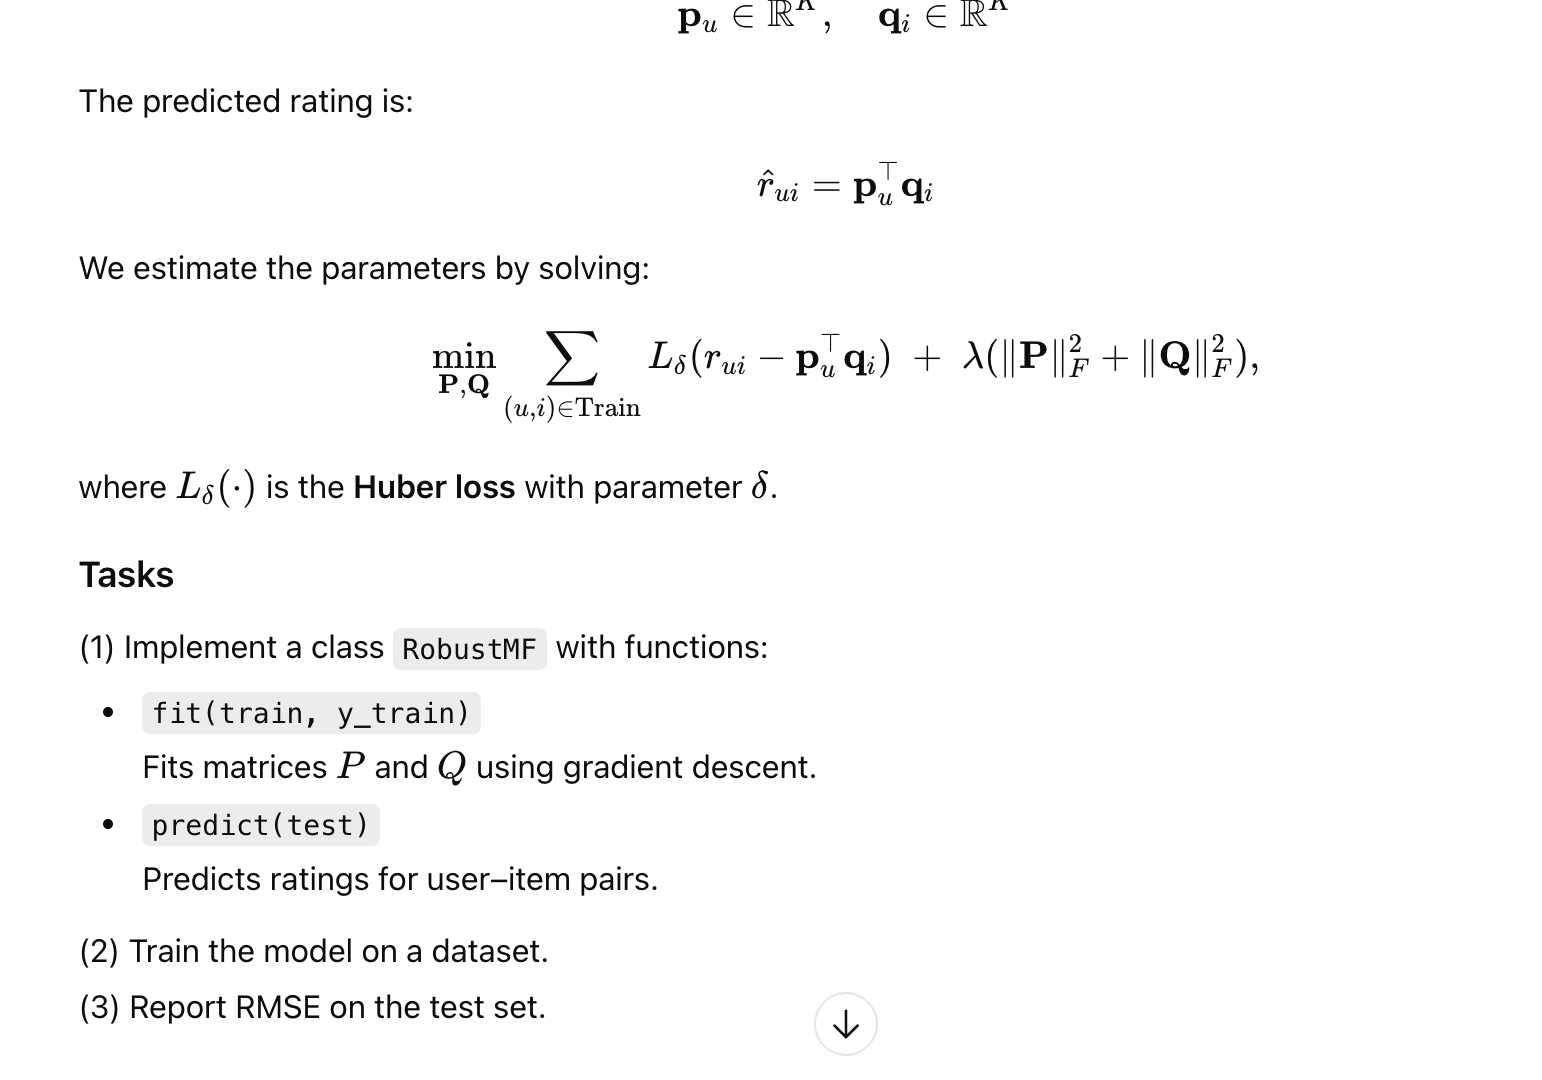

In [ ]:
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

class RobustMF:
    def __init__(self, n_user, n_item, K=10, lam=0.1, delta=1.35, lr=0.01, epochs=50):
        self.n_user = n_user
        self.n_item = n_item
        self.K = K
        self.lam = lam
        self.delta = delta
        self.lr = lr
        self.epochs = epochs
        
        # initialize latent factors
        self.P = 0.1 * np.random.randn(n_user, K)
        self.Q = 0.1 * np.random.randn(n_item, K)

    def huber_grad(self, r):
        """Gradient of Huber loss."""
        if abs(r) <= self.delta:
            return r               # quadratic region
        else:
            return self.delta * np.sign(r)  # linear region

    def fit(self, train, y_train):
        for epoch in range(self.epochs):

            for (u, i), rating in zip(train, y_train):
                u = int(u) - 1
                i = int(i) - 1

                pred = self.P[u].dot(self.Q[i])
                error = rating - pred

                g = self.huber_grad(error)

                # Update rules
                self.P[u] += self.lr * ( g * self.Q[i] - self.lam * self.P[u] )
                self.Q[i] += self.lr * ( g * self.P[u] - self.lam * self.Q[i] )

            # optional: print progress
            if (epoch+1) % 10 == 0:
                print(f"Epoch {epoch+1}/{self.epochs} complete.")

    def predict(self, test):
        preds = []
        for u, i in test:
            preds.append(self.P[int(u)-1].dot(self.Q[int(i)-1]))
        return np.array(preds)


In [ ]:
import pandas as pd

train_df = pd.read_csv('https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/netflix/train.csv')
test_df  = pd.read_csv('https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/netflix/test.csv')

full = pd.concat([train_df, test_df], axis=0)
n_user = full["user_id"].nunique()
n_item = full["movie_id"].nunique()

# numpy arrays
train_X = train_df[["user_id", "movie_id"]].values
test_X  = test_df[["user_id", "movie_id"]].values
y_train = train_df["rating"].values
y_test  = test_df["rating"].values


## **Q4.1: Data Pre-processing for Dense and Categorical Features**

The goal of this task is to preprocess the dense and categorical features for both users and items. The preprocessing steps involve:

1. **Categorizing features**: Separate the features into **continuous** (dense) and **discrete** (categorical) features.
2. **Standardizing continuous features**: Use a `StandardScaler` to standardize the continuous features.
3. **Encoding discrete features**: Use a `LabelEncoder` to encode the discrete features.

Implement the preprocessing steps and provide the preprocessed data for further analysis.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load dataset
df = pd.read_csv(
    'https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/refs/heads/main/dataset/udemy/udemy_clean.csv'
)

# Separate features and target
X = df.iloc[:, :-1]
y = df["Rating"]

# Identify numerical and categorical features
numerical_features = ["User_vote", "Total_hours", "Lecture"]
categorical_features = ["Instructor", "Level"]

# Standardize numerical features
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Label encode categorical features
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# X is now fully preprocessed
X.head()


,Instructor,User_vote,Total_hours,Lecture,Level
0,545,14.145924,1.088768,0.796217,0
1,2341,13.767311,-0.497849,0.078916,0
2,90,13.647685,2.718266,6.576013,0
3,2095,13.571222,1.774872,4.299959,0
4,2095,13.256740,-0.240560,-0.265941,3


## **Q4.2: Implementing a Plain Recommender System (PlainRS) using TensorFlow**

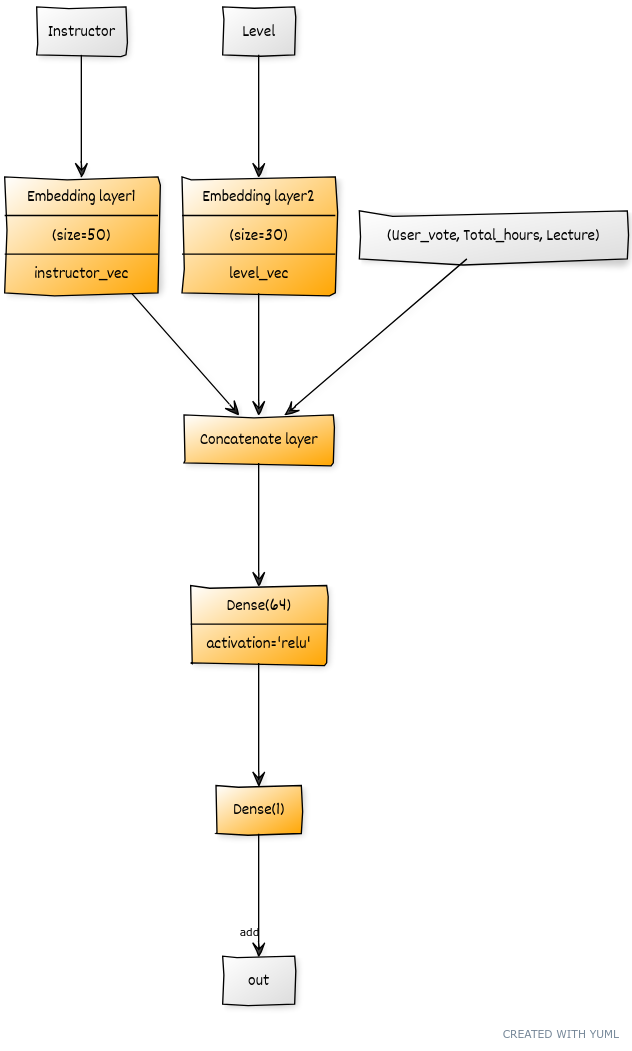

In [5]:
pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 MB 43.5 MB/s  0:00:04m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 52.2 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 676.9/676.9 kB 20.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 52.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 43.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 52.7 MB/s  0:00:00 eta 0:00:01
  Attempting uninstall: typing_extensions━━━━━━━━━━━━━━━━━━━━━━━━━  1/18 [libclang]
    Found existing installation: typing_extensions 4.11.0━━━━━  1/18 [libclang]
    Uninstalling typing_extensions-4.11.0:━━━━━━━━━━━━━━━━━━━━  1/18 [libclang]
      Successfully uninstalled typing_extensions-4.11.0━━━━━━━━━━━  3/18 [typing_extensions]
  Attempting uninstall: protobuf━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  3/18 [typing_extensions]
    Found existing installation: protobuf 4.25.3━━━━━━━━━━━━━━  3/18 [typing_exte

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

class PlainRS(keras.Model):
    def __init__(self, num_instructors, num_levels,
                 instruct_size=50, level_size=30):
        super().__init__()

        self.instruct_embed = layers.Embedding(num_instructors, instruct_size)
        self.level_embed = layers.Embedding(num_levels, level_size)

        self.concat = layers.Concatenate()
        self.dense1 = layers.Dense(64, activation='relu')
        self.out = layers.Dense(1)

    def call(self, inputs):

        instructor = inputs[:, 0]
        numerical = inputs[:, 1:4]
        level = inputs[:, 4]

        instruct_vec = self.instruct_embed(instructor)
        level_vec = self.level_embed(level)

        joint = self.concat([instruct_vec, level_vec, numerical])

        x = self.dense1(joint)
        return self.out(x)


In [ ]:
n_instructor = X["Instructor"].nunique()
n_levels = X["Level"].nunique()

model = PlainRS(n_instructor, n_levels)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=[
        keras.metrics.RootMeanSquaredError(),
        keras.metrics.MeanAbsoluteError()
    ]
)

callback = keras.callbacks.EarlyStopping(
    monitor="val_root_mean_squared_error",
    patience=5,
    mode="min",
    restore_best_weights=True
)

model.fit(
    X, y,
    epochs=20,
    batch_size=512,
    validation_split=0.3,
    callbacks=[callback]
)


Epoch 1/20


## **Q4.3: Implementing a Dizzy Plain Recommender System (DizzyRS) using TensorFlow**

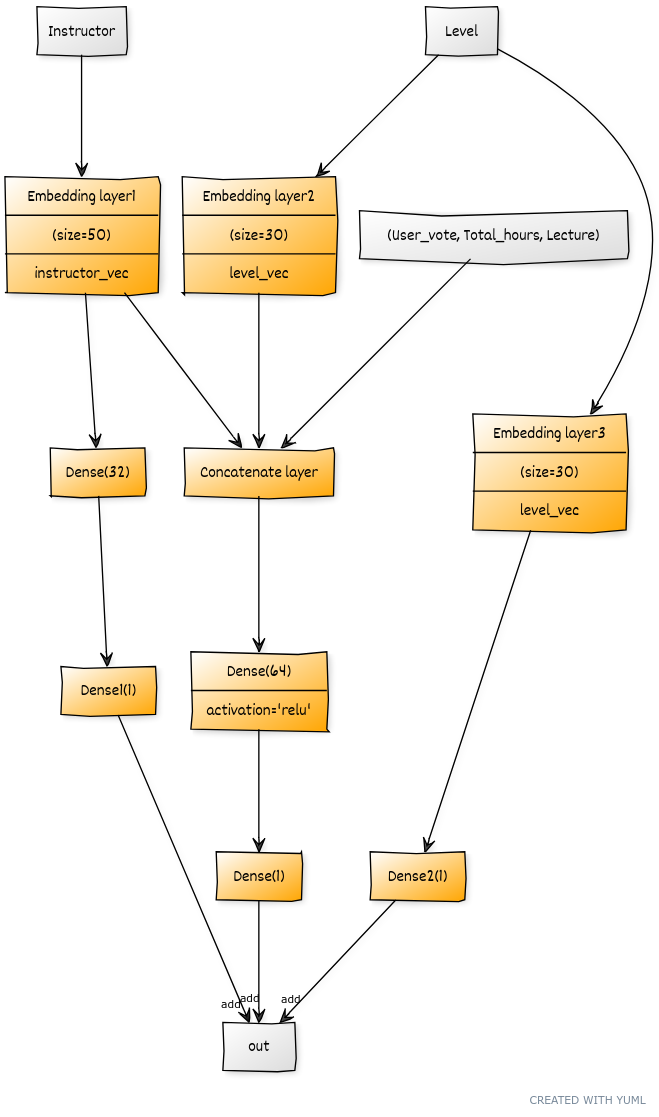

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

class DizzyRS(keras.Model):
    def __init__(self, num_instructors, num_levels,
                 instruct_size=50, level_size=30):
        super().__init__()

        # Embeddings
        self.instruct_embed = layers.Embedding(num_instructors, instruct_size)
        self.level_embed = layers.Embedding(num_levels, level_size)
        self.level_embed2 = layers.Embedding(num_levels, level_size)

        # Middle branch
        self.concat = layers.Concatenate()
        self.middle_dense1 = layers.Dense(64, activation='relu')
        self.middle_dense2 = layers.Dense(1)

        # Left branch (instructor only)
        self.left_dense1 = layers.Dense(32, activation='relu')
        self.left_dense2 = layers.Dense(1)

        # Right branch (level only)
        self.right_dense = layers.Dense(1)

    def call(self, inputs):

        # Extract parts
        instructor = inputs[:, 0]
        numerical = inputs[:, 1:4]
        level = inputs[:, 4]

        # === Middle branch ===
        instruct_vec = self.instruct_embed(instructor)
        level_vec = self.level_embed(level)

        middle_joint = self.concat([instruct_vec, level_vec, numerical])
        middle_hidden = self.middle_dense1(middle_joint)
        out_middle = self.middle_dense2(middle_hidden)

        # === Left branch ===
        left_vec = self.instruct_embed(instructor)
        left_hidden = self.left_dense1(left_vec)
        out_left = self.left_dense2(left_hidden)

        # === Right branch ===
        level_vec2 = self.level_embed2(level)
        out_right = self.right_dense(level_vec2)

        # Final output = sum of branches
        return out_left + out_middle + out_right


In [ ]:
n_instructor = X["Instructor"].nunique()
n_levels = X["Level"].nunique()

model = DizzyRS(n_instructor, n_levels)
opt = keras.optimizers.Adam(1e-3)

model.compile(
    optimizer=opt,
    loss="mse",
    metrics=[
        keras.metrics.RootMeanSquaredError(),
        keras.metrics.MeanAbsoluteError()
    ]
)

callback = keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5,
    mode='min',
    restore_best_weights=True
)

model.fit(
    X, y,
    epochs=20,
    batch_size=512,
    validation_split=0.3,
    callbacks=[callback]
)


Epoch 1/20
